In [1]:
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, geo_tools
import datetime as dt
import glob
import gsw
import pickle
import matplotlib as mpl
import cmocean
from scipy import stats as spst
import scipy.optimize as scopt
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
fpath='/ocean/eolson/MEOPAR/obs/UBCSolar'
flist=np.sort([el for el in os.listdir(fpath) if el.endswith('.txt')])

In [3]:
dflist=list()
for ifile in flist:
    dflist.append(pd.read_csv(os.path.join(fpath,ifile),names=['YYYYMMDD','HHMMSS','solar_Wm2','Tem_degC'],
               sep=' ',skipinitialspace=True,dtype={0:str,1:str,2:float,3:float}))
df=pd.concat(dflist,ignore_index=True)

In [4]:
df['dtUTC']=[dt.datetime.strptime((dd+'{:0>6}'.format(tt)),'%Y%m%d%H%M%S') \
             for dd,tt in zip(df['YYYYMMDD'],df['HHMMSS'])]

In [5]:
meshPath='/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m01d01.nc'
with nc.Dataset(meshPath) as fmesh:
    navlon=np.squeeze(np.copy(fmesh.variables['nav_lon'][:,:]-360))
    navlat=np.squeeze(np.copy(fmesh.variables['nav_lat'][:,:]))
jj,ii = geo_tools.find_closest_model_point(-123.252380, 49.263282, navlon,navlat,grid='GEM2.5')
df['i']=ii
df['j']=jj

In [6]:
flen=1
namfmt='wind'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'solar':'ops',}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ops':1,}
PATH='/results/forcing/atmospheric/GEM2.5/operational/'
dstart=dt.datetime(2014,9,12)
dend=df['dtUTC'].max()

In [7]:
data=et.matchData(df,filemap,fdict,dstart,dend,namfmt,PATH,flen,maskName='ops',sdim=2,preIndexed=True)

ftype=ops, are you sure? (if yes, add to list)
progress: 0.0%
progress: 2.378336211120149%
progress: 4.756672422240298%
progress: 7.135008633360447%
progress: 9.513344844480596%
progress: 11.891681055600746%
progress: 14.270017266720894%
progress: 16.64835347784104%
progress: 19.02668968896119%
progress: 21.40502590008134%
progress: 23.78336211120149%
progress: 26.161698322321637%
progress: 28.540034533441787%
progress: 30.918370744561933%
progress: 33.29670695568208%
progress: 35.67504316680223%
progress: 38.05337937792238%
progress: 40.431715589042525%
progress: 42.81005180016268%
progress: 45.188388011282825%
progress: 47.56672422240298%
progress: 49.945060433523125%
progress: 52.323396644643275%
progress: 54.70173285576342%
progress: 57.080069066883574%
progress: 59.458405278003724%
progress: 61.83674148912387%
progress: 64.21507770024402%
progress: 66.59341391136417%
progress: 68.97175012248431%
progress: 71.35008633360447%
progress: 73.72842254472461%
progress: 76.10675875584477%

In [8]:
data

,YYYYMMDD,HHMMSS,solar_Wm2,Tem_degC,dtUTC,i,j,mod_solar
0,20140912,0,385.0,18.8,2014-09-12 00:00:00,154,143,474.885834
1,20140912,1500,350.0,18.8,2014-09-12 00:15:00,154,143,474.885834
2,20140912,3000,312.0,18.9,2014-09-12 00:30:00,154,143,474.885834
3,20140912,4500,271.0,18.8,2014-09-12 00:45:00,154,143,474.885834
4,20140912,10000,230.0,18.7,2014-09-12 01:00:00,154,143,305.794434
...,...,...,...,...,...,...,...,...
210226,20201008,224500,300.0,16.4,2020-10-08 22:45:00,154,143,106.828194
210227,20201008,230000,187.0,16.4,2020-10-08 23:00:00,154,143,124.028473
210228,20201008,231500,195.0,0.0,2020-10-08 23:15:00,154,143,124.028473
210229,20201008,233000,154.0,0.0,2020-10-08 23:30:00,154,143,124.028473


Text(0, 0.5, 'GEM2.5')

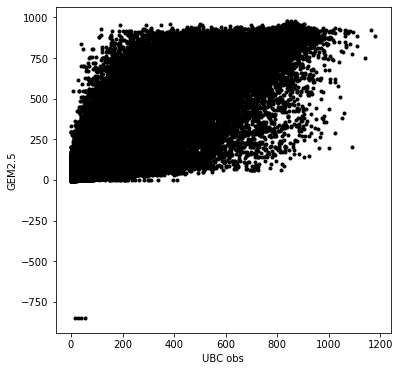

In [18]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.plot(data['solar_Wm2'],data['mod_solar'],'k.')
ax.set_xlabel('UBC obs')
ax.set_ylabel('GEM2.5')

In [10]:
np.shape(np.array([data['solar_Wm2'], data['mod_solar']]).T)

(210231, 2)

Text(0, 0.5, 'Count')

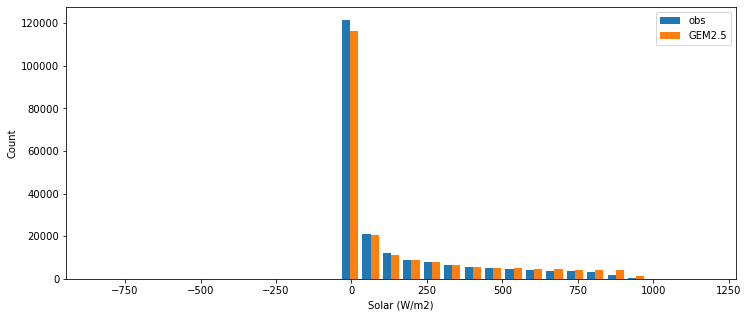

In [11]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.hist(np.array([data['solar_Wm2'], data['mod_solar']]).T,30);
ax.legend(labels=('obs','GEM2.5'))
ax.set_xlabel('Solar (W/m2)')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

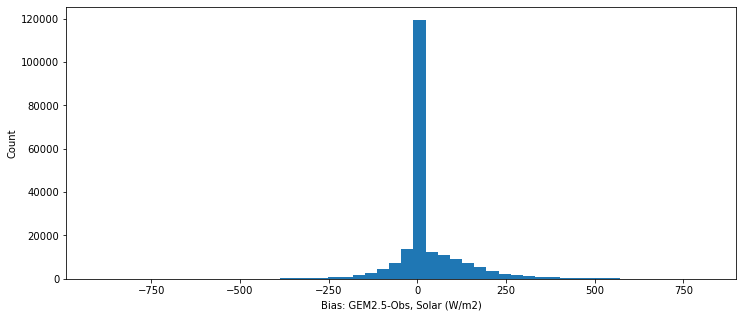

In [12]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.hist(data['mod_solar']-data['solar_Wm2'],50);
ax.set_xlabel('Bias: GEM2.5-Obs, Solar (W/m2)')
ax.set_ylabel('Count')

In [13]:
data.loc[data.mod_solar<-700]

,YYYYMMDD,HHMMSS,solar_Wm2,Tem_degC,dtUTC,i,j,mod_solar
195173,20200504,130000,15.0,6.3,2020-05-04 13:00:00,154,143,-849.998169
195174,20200504,131500,26.0,6.6,2020-05-04 13:15:00,154,143,-849.998169
195175,20200504,133000,41.0,6.8,2020-05-04 13:30:00,154,143,-849.998169
195176,20200504,134500,53.0,7.1,2020-05-04 13:45:00,154,143,-849.998169


Text(0, 0.5, 'Negative GEM2.5 Values')

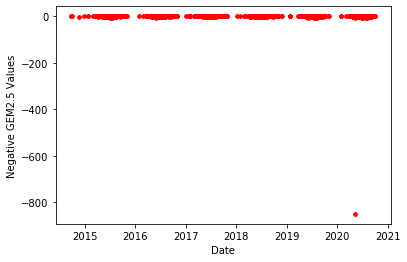

In [19]:
dataneg=data.loc[data.mod_solar<0]
plt.plot(dataneg['dtUTC'],dataneg['mod_solar'],'r.')
plt.xlabel('Date')
plt.ylabel('Negative GEM2.5 Values')

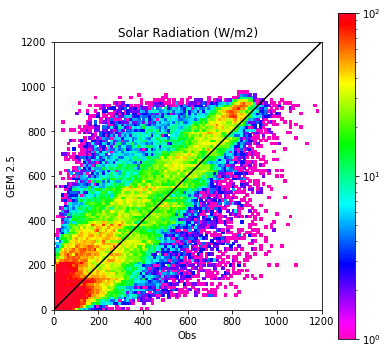

In [20]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
_,_,_,m=ax.hist2d(data['solar_Wm2'],data['mod_solar'],bins=np.linspace(0,1200,100),norm=mpl.colors.LogNorm(), 
          cmap=mpl.cm.gist_rainbow_r,vmin=1,vmax=10**2);
ax.plot((0,1200),(0,1200),'k-')
ax.set_xlabel('Obs')
ax.set_ylabel('GEM 2.5')
ax.set_aspect(1)
ax.set_title('Solar Radiation (W/m2)')
fig.colorbar(m,ax=ax)

In [16]:
N, modmean, obsmean, bias, RMSE, WSS=et.stats(data['solar_Wm2'],data['mod_solar'])
print('N:',N)
print('obsmean:',obsmean)
print('bias"',bias)
print('RMSE:',RMSE)
print('WSS:',WSS)

N: 210231
obsmean: 134.4956671470906
bias" 25.037006737438304
RMSE: 102.96341594647286
WSS: 0.9509871602505735


Text(0, 0.5, 'GEM2.5-obs')

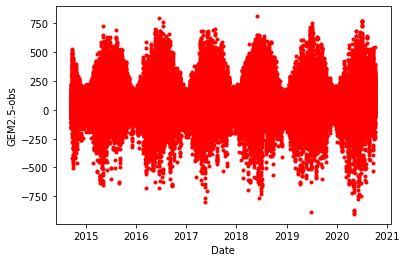

In [23]:
#data2=data.loc[np.abs(data.mod_solar-data.solar_Wm2)>400]
plt.plot(data['dtUTC'],data['mod_solar']-data['solar_Wm2'],'r.')
plt.xlabel('Date')
plt.ylabel('GEM2.5-obs')

In [30]:
data['Hour']=[ii.hour for ii in data['dtUTC']]

In [33]:
data['Month']=[ii.month for ii in data['dtUTC']]

Text(0, 0.5, 'GEM2.5-obs')

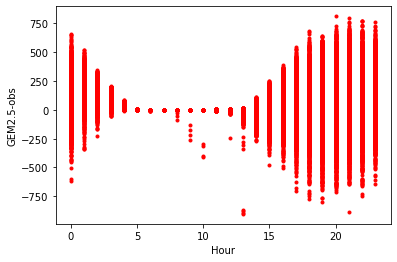

In [32]:
plt.plot(data['Hour'],data['mod_solar']-data['solar_Wm2'],'r.')
plt.xlabel('Hour')
plt.ylabel('GEM2.5-obs')

Text(0, 0.5, 'GEM2.5-obs')

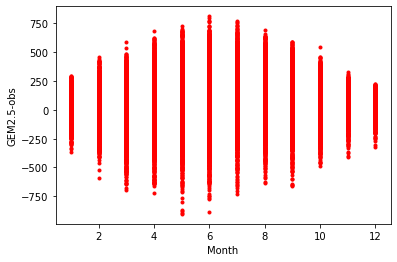

In [34]:
plt.plot(data['Month'],data['mod_solar']-data['solar_Wm2'],'r.')
plt.xlabel('Month')
plt.ylabel('GEM2.5-obs')